# Modelos de Regresión

### Se presentan una serie de modelos de regresion para predecir el precio de las propiedades.

In [134]:
# librerias
import pandas as pd
import numpy as np
import os
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Transformaciones y Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

In [63]:
#Leer datos
#
df = pd.read_pickle('../data_clean/data_limpia.pkl')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415 entries, 0 to 1546
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   descripcion              1415 non-null   object 
 1   ubicacion                1415 non-null   object 
 2   banio                    1415 non-null   float64
 3   cantidad_pisos_edificio  1415 non-null   float64
 4   departamentos_por_piso   1415 non-null   float64
 5   piso_departamento        1415 non-null   float64
 6   orientacion              1415 non-null   object 
 7   estacionamiento          1415 non-null   float64
 8   bodega                   1415 non-null   float64
 9   precio_en_uf             1415 non-null   float64
 10  dormitorio_nuevo         1415 non-null   float64
 11  superficie_total_nuevo   1415 non-null   float64
 12  gastos_comunes_nuevo     1415 non-null   float64
 13  latitud                  1415 non-null   float64
 14  longitud                

Separando en data de entrenamiento - data de prueba

In [65]:
df.head(2)

,descripcion,ubicacion,banio,cantidad_pisos_edificio,departamentos_por_piso,piso_departamento,orientacion,estacionamiento,bodega,precio_en_uf,...,superficie_total_nuevo,gastos_comunes_nuevo,latitud,longitud,anio_construccion,loggia,piscina,quincho,comedor,metro
0,No deje de visitar... gran departamento u ofic...,"Av. Providencia 1200 - 1500, Providencia, Chil...",2.0,6.0,4.0,6.0,N,1.0,1.0,5228.57,...,103.0,45000.0,-33.428185,-70.618222,1971.0,No,No,No,Si,Si
1,Excelente departamento en Av. El Llano Suberca...,"Llano Subercaseaux, San Miguel, Chile, El Llan...",2.0,21.0,4.0,19.0,S,1.0,1.0,5290.00,...,90.0,90000.0,-33.485147,-70.650404,2011.0,No,Si,Si,No,Si


In [66]:
df['orientacion'].value_counts()

O       735
NP      134
N       132
SO      112
P       112
S        91
SP       77
NOSP     22
Name: orientacion, dtype: int64

In [67]:
#las variables con frecuencia bajo 100 se agrupan en un nuevo grupo llamado otros
df['orientacion'] = df['orientacion'].replace("S", "other")
df['orientacion'] = df['orientacion'].replace("SP", "other")
df['orientacion'] = df['orientacion'].replace("NOSP", "other")

In [68]:
df['orientacion'].value_counts()

O        735
other    190
NP       134
N        132
SO       112
P        112
Name: orientacion, dtype: int64

In [70]:
wrapper = textwrap.TextWrapper(width=100)

In [72]:
# list( train.select_dtypes( include= 'integer') )  # Comando base
print( 'Columnas Object' )
print( wrapper.fill( str( list( df.select_dtypes( include= 'object') ) ) ) )
print( 'Columnas Entero' )
print( wrapper.fill( str( list( df.select_dtypes( include= 'integer') ) ) ) )
print( 'Columnas Float' )
print( wrapper.fill( str( list( df.select_dtypes( include= 'floating') ) ) ) )
print( 'Columnas Verdadero Falso' )
print( wrapper.fill( str( list( df.select_dtypes( include= 'bool') ) ) ) )
print( 'Columnas Categoricas' )
print( wrapper.fill( str( list( df.select_dtypes( include= 'category') ) ) ) )
print( 'Columnas Fecha' )
print( wrapper.fill( str( list( df.select_dtypes( include= 'datetime') ) ) ) )

Columnas Object
['descripcion', 'ubicacion', 'orientacion', 'loggia', 'piscina', 'quincho', 'comedor', 'metro']
Columnas Entero
[]
Columnas Float
['banio', 'cantidad_pisos_edificio', 'departamentos_por_piso', 'piso_departamento',
'estacionamiento', 'bodega', 'precio_en_uf', 'dormitorio_nuevo', 'superficie_total_nuevo',
'gastos_comunes_nuevo', 'latitud', 'longitud', 'anio_construccion']
Columnas Verdadero Falso
[]
Columnas Categoricas
[]
Columnas Fecha
[]


In [73]:
df.select_dtypes(include=['object']).columns.tolist()

['descripcion',
 'ubicacion',
 'orientacion',
 'loggia',
 'piscina',
 'quincho',
 'comedor',
 'metro']

In [74]:
df.select_dtypes(exclude=['object']).columns.tolist()

['banio',
 'cantidad_pisos_edificio',
 'departamentos_por_piso',
 'piso_departamento',
 'estacionamiento',
 'bodega',
 'precio_en_uf',
 'dormitorio_nuevo',
 'superficie_total_nuevo',
 'gastos_comunes_nuevo',
 'latitud',
 'longitud',
 'anio_construccion']

In [116]:
categorial_features = [ 'orientacion','loggia','piscina',
                    'quincho','comedor','metro']

numeric_features = ['banio','cantidad_pisos_edificio','departamentos_por_piso',
                    'piso_departamento','estacionamiento','bodega',#'precio_en_uf',
                    'dormitorio_nuevo','superficie_total_nuevo','gastos_comunes_nuevo',
                    'latitud','longitud','anio_construccion']

La siguiente instruccion genera un pipeline que escala las variables cuantitativas mediante StandarScaler() y codifica las cualitativas con OneHotEncoder().

In [222]:
numeric_transformer     = Pipeline(steps = [("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown = "ignore")

preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorial_features),
    ], 
)

In [118]:
from sklearn import set_config
set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['banio', 'cantidad_pisos_edificio',
                                  'departamentos_por_piso', 'piso_departamento',
                                  'estacionamiento', 'bodega',
                                  'dormitorio_nuevo', 'superficie_total_nuevo',
                                  'gastos_comunes_nuevo', 'latitud', 'longitud',
                                  'anio_construccion']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['orientacion', 'loggia', 'piscina', 'quincho',
                                  'comedor', 'metro'])])

## Modelo

In [223]:
X = df.drop(columns=['descripcion','ubicacion','precio_en_uf'])
X.columns

Index(['banio', 'cantidad_pisos_edificio', 'departamentos_por_piso',
       'piso_departamento', 'orientacion', 'estacionamiento', 'bodega',
       'dormitorio_nuevo', 'superficie_total_nuevo', 'gastos_comunes_nuevo',
       'latitud', 'longitud', 'anio_construccion', 'loggia', 'piscina',
       'quincho', 'comedor', 'metro'],
      dtype='object')

In [224]:
y = pd.DataFrame(df['precio_en_uf'])
y.columns

Index(['precio_en_uf'], dtype='object')

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=1234)

In [226]:
print('Dim de X_train: ', X_train.shape)
print('Dim de X_test: ', X_test.shape)
print('Dim de y_train: ', y_train.shape)
print('Dim de y_test: ', y_test.shape)

Dim de X_train:  (1132, 18)
Dim de X_test:  (283, 18)
Dim de y_train:  (1132, 1)
Dim de y_test:  (283, 1)


In [227]:
# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     subsample=0.5,
#     colsample_bytree=0.5,
#     seed=0
# )

model = xgb.XGBRegressor()

In [228]:
# Se define pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

In [242]:
# Define the hyperparameters for grid search
param_grid = {
     'model__n_estimators': [100, 500, 1000],
     'model__max_depth': [3, 4, 5, 6, 7],
     'model__learning_rate': [0.1, 0.01, 0.001],
     'model__subsample': [0.8, 0.9, 1],
     'model__colsample_bytree': [0.8, 0.9, 1]
}

In [243]:
# Define the evaluation metrics
scoring = {'mse': 'neg_mean_squared_error',
           'r2': 'r2',
           'mae': 'neg_mean_absolute_error'}

In [244]:
# Grid search con cross-validation
grid = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='mse', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['banio',
                                                                          'cantidad_pisos_edificio',
                                                                          'departamentos_por_piso',
                                                                          'piso_departamento',
                                                                          'estacionamiento',
                                                                          'bodega',
                                                                          'dormitorio_nuevo',
                                                                          'superficie_total_nuevo',
                                                                          'gastos_comunes_nuevo',
                                                                          'latitud',
                                                                          'longitud',
                                                                          'anio_cons...
                                                     predictor=None,
                                                     random_state=None,
                                                     reg_alpha=None,
                                                     reg_lambda=None, ...))]),
             param_grid={'model__colsample_bytree': [0.8, 0.9, 1],
                         'model__learning_rate': [0.1, 0.01, 0.001],
                         'model__max_depth': [3, 4, 5, 6, 7],
                         'model__n_estimators': [100, 500, 1000],
                         'model__subsample': [0.8, 0.9, 1]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [246]:
# Mejores hyperparametros
print("Mejores hyperparametros: ", grid.best_params_)

Mejores hyperparametros:  {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 1000, 'model__subsample': 0.9}


In [200]:
# Obtener puntaje de R-cuadrado promedio y desviación estándar en cada parte
#scores = cross_val_score(grid.best_estimator_, X, y, cv=10)
#print("R-cuadrado: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [248]:
# Evaluacion del modelo en el conjunto de train y de test 

modelo_final = grid.best_estimator_
y_test_pred = modelo_final.predict(X_test)
y_train_pred = modelo_final.predict(X_train)

mse1 = mean_squared_error(y_train, y_train_pred)
mse2 = mean_squared_error(y_test, y_test_pred)
r21 = r2_score(y_train, y_train_pred)
r22 = r2_score(y_test, y_test_pred)
mae1 = mean_absolute_error(y_train, y_train_pred)
mae2 = mean_absolute_error(y_test, y_test_pred)

print('Train')
print("Train - Mean squared error: ", mse1)
print("Train - R2 score: ", r21)
print("Train - Mean absolute error: ", mae1)
print('\nTest')
print("Test - Mean squared error: ", mse2)
print("Test - R2 score: ", r22)
print("Test - Mean absolute error: ", mae2)

Train
Train - Mean squared error:  260201.33133419178
Train - R2 score:  0.974700764620963
Train - Mean absolute error:  369.6152857631508

Test
Test - Mean squared error:  805188.3715641291
Test - R2 score:  0.9095723861211786
Test - Mean absolute error:  604.4199320115807


In [249]:
grid.best_estimator_.named_steps['model'].feature_importances_ 

array([0.14309943, 0.00404696, 0.003617  , 0.00507073, 0.19022451,
       0.00364289, 0.01075397, 0.35908955, 0.14037785, 0.0282931 ,
       0.03842942, 0.00867755, 0.00337421, 0.00360977, 0.00313366,
       0.00387631, 0.00571428, 0.00306053, 0.00518475, 0.00277115,
       0.00452093, 0.00454515, 0.00510533, 0.0048882 , 0.00399052,
       0.00447474, 0.00333463, 0.00309284], dtype=float32)

In [250]:
importances = list(zip(X.columns, grid.best_estimator_.named_steps['model'].feature_importances_))
importances.sort(key=lambda x: x[1], reverse=True)
data = pd.DataFrame(importances, columns = ['Variable','Importancia'])
data.sort_values(by="Importancia", ascending=False)

,Variable,Importancia
0,dormitorio_nuevo,0.359090
1,orientacion,0.190225
2,banio,0.143099
3,superficie_total_nuevo,0.140378
4,latitud,0.038429
5,gastos_comunes_nuevo,0.028293
6,bodega,0.010754
7,longitud,0.008678
8,comedor,0.005714
9,piso_departamento,0.005071


### Guardar modelo

In [ ]:
# modelo xgboost
filename = 'modelxgboost.pkl'
pickle.dump(modelo_final, open(filename, 'wb'))


In [ ]:
modelo_xgboost = pickle.load(open('modelo_final', 'rb'))

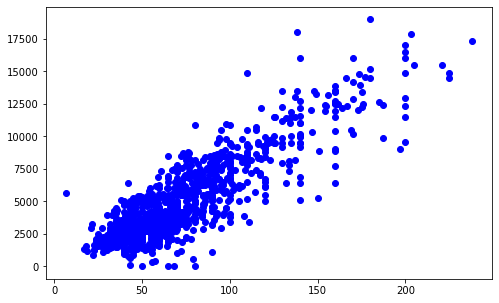

In [146]:
# Visualizar resultados con gráficas
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_train['superficie_total_nuevo'], y_train, color='blue', label='Datos de entrenamiento')
ax.set_xlabel('superficie_total_nuevo')
ax.set_ylabel('precio_uf')
ax.set_title('superficie_total_nuevo v/s precio_uf')
plt.show()

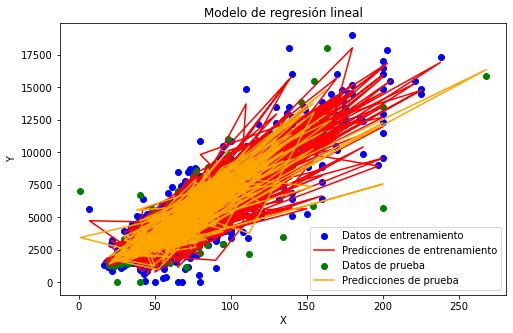

In [148]:
# Visualizar resultados con gráficas
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_train['superficie_total_nuevo'], y_train, color='blue', label='Datos de entrenamiento')
ax.plot(X_train['superficie_total_nuevo'], y_train_pred, color='red', label='Predicciones de entrenamiento')
ax.scatter(X_test['superficie_total_nuevo'], y_test, color='green', label='Datos de prueba')
ax.plot(X_test['superficie_total_nuevo'], y_test_pred, color='orange', label='Predicciones de prueba')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Modelo de regresión lineal')
ax.legend()
plt.show()